In [1]:
import os
from os.path import join
import sys
import random
import math
import re
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import tqdm
import pandas as pd
from collections import defaultdict
import random
import pickle
import cv2
cv2.ocl.setUseOpenCL(False)

from config import Config
import utils
import model as modellib
import visualize
from model import log
from config import Config
import augs

%matplotlib inline 

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [3]:
def makedirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'experiments', 'attempt4')
makedirs(MODEL_DIR)

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# new

In [4]:
data = pd.read_csv('/data/sample_submission_old.csv')

classes = [
    'dining_table',
    'shelf', #
    'armchair',
    'lamp', #
    'couch', # 
    'desk',
    'chair',  
    'bed', # 
    'wardrobe' #
]
# classes = set(json.loads(data.iloc[0]['result'])['aabb'].keys())
# classes

In [8]:
def load_samples(csv_filepath, dirpath, classes):
    def read_objs(marks):
        result = []
        try:
            marks = marks['aabb']
            if set(marks.keys()) != classes:
                raise Exception()
            for k, v in marks.items():
                for polygon in v:
                    polygon = np.array(polygon)
                    x, y = polygon[:, 0], polygon[:, 1]
                    left, top, right, bottom = np.min(x), np.min(y), np.max(x), np.max(y)
                    result.append({
                        'cls': k,
                        'bbox': {
                            'left': left,
                            'top': top,
                            'right': right,
                            'bottom': bottom
                        }
                    })
        except:
            return None
        return result
        
    samples = []
    data = pd.read_csv(csv_filepath)
    for k, v in list(data.iterrows()):
        id = v['id']
        filepath = join(dirpath, '%06d.jpg' % (int(id)))
        if not os.path.exists(filepath):
            continue
        img = cv2.imread(filepath)
        h, w = img.shape[:2]
        resolution = {'w': w, 'h': h}
        objs = read_objs(json.loads(v['result']))
        if objs is None:
            print('Skipping image with id {}'.format(id))
            continue
        samples.append({
            'filepath': filepath,
            'resolution': resolution,
            'objs': objs
        })
    return samples

In [67]:
samples = np.array(load_samples('/data/train.csv', '/data/images', classes))

Skipping image with id 5332


In [6]:
def show_sample(sample):
    img = cv2.imread(sample['filepath'])[:, :, ::-1]
    h, w = sample['resolution']['h'], sample['resolution']['w']
    for obj in sample['objs']:
        left, top, right, bottom = (
            int(obj['bbox']['left'] * w),
            int(obj['bbox']['top'] * h),
            int(obj['bbox']['right'] * w),
            int(obj['bbox']['bottom'] * h)
        )
        img = img.copy()
        cv2.rectangle(img, (left, top), (right, bottom), (255, 255, 255), 3)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.show()

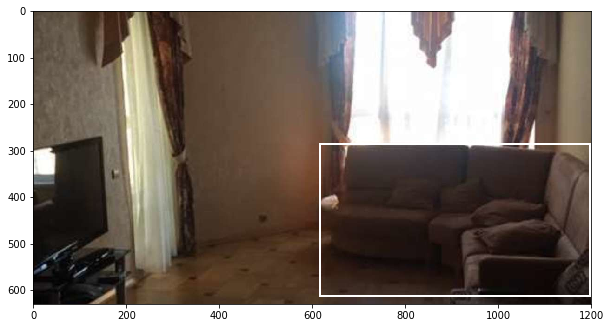

In [70]:
show_sample(samples[2])

In [7]:
def count_objects(samples):
    result = defaultdict(int)
    for sample in samples:
        for obj in sample['objs']:
            result[obj['cls']] += 1
    return result

def normalize(d, fraq):
    result = {}
    for k, v in d.items():
        result[k] = v / fraq
    return result

def get_error(counts, all_counts):
    error = 0
    for k, v in all_counts.items():
        cur_error = abs(counts.get(k, 0) / v - 1)
        error = max(cur_error, error)
    return error

In [92]:
all_counts = count_objects(samples)
all_counts

defaultdict(int,
            {'armchair': 437,
             'bed': 708,
             'chair': 1580,
             'couch': 1146,
             'desk': 798,
             'dining_table': 555,
             'lamp': 2168,
             'shelf': 3206,
             'wardrobe': 800})

In [101]:
val_fraq = 0.075
error_th = 0.05
while True:
    indexes = list(range(len(samples)))
    random.shuffle(indexes)
    train_size = int(len(samples) * (1 - val_fraq))
    train_indexes = indexes[:train_size]
    val_indexes = indexes[train_size:]
    train_counts = normalize(count_objects(samples[train_indexes]), 1 - val_fraq)
    val_count = normalize(count_objects(samples[val_indexes]), val_fraq)
    train_error = get_error(train_counts, val_count)
    val_error = get_error(train_counts, val_count)
    error = max(train_error, val_error)
    if error < error_th:
        break

In [ ]:
train_samples, val_samples = samples[train_indexes], samples[val_indexes]
split = train_samples, val_samples
pickle.dump(split, open(join(MODEL_DIR, 'split.pickle'), 'wb'))

In [5]:
class WhateverDataset(utils.Dataset):
    def init(self, classes, samples):
        classes = list(classes)
        source = "furniture"
        for i, cls in enumerate(classes):
            self.add_class(source, i + 1, cls)

        for i in range(len(samples)):
            filepath, resolution, objs = (
                samples[i]['filepath'],
                samples[i]['resolution'],
                samples[i]['objs']
            )
                
            self.add_image(
                source, 
                path=None,
                image_id=i,
                filepath=filepath,
                resolution=resolution,
                objs=objs
            )
                           
    def load_image(self, index):
        filepath = self.image_info[index]['filepath']
        img = cv2.imread(filepath)[:, :, ::-1]
        return img
                           
    def load_mask(self, index):
        image_info = self.image_info[index]
        objs = image_info['objs']
        if len(objs) == 0:
            return super(WhateverDataset, self).load_mask(index)
        h, w = image_info['resolution']['h'], image_info['resolution']['w']
        mask = np.zeros((h, w, len(objs)), dtype=np.uint8)
        for i, obj in enumerate(objs):
            left, top, right, bottom = (
                int(obj['bbox']['left'] * w),
                int(obj['bbox']['top'] * h),
                int(obj['bbox']['right'] * w),
                int(obj['bbox']['bottom'] * h)
            )
            mask[top:bottom, left:right, i] = 1
        
        class_ids = np.array([self.class_names.index(obj['cls']) for obj in objs], dtype=np.int32)
        return mask, class_ids
                
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "furniture":
            return info["furniture"]
        else:
            super(self.__class__).image_reference(self, image_id)

In [6]:
train_samples, val_samples = pickle.load(open('./experiments/attempt1/split.pickle', 'rb'))

In [7]:
# Training dataset
dataset_train = WhateverDataset()
dataset_train.init(classes, train_samples)
dataset_train.prepare()

# Validation dataset
dataset_val = WhateverDataset()
dataset_val.init(classes, val_samples)
dataset_val.prepare()

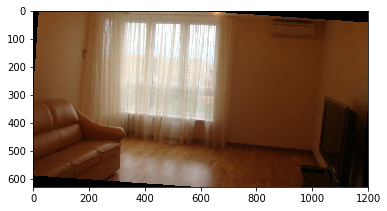

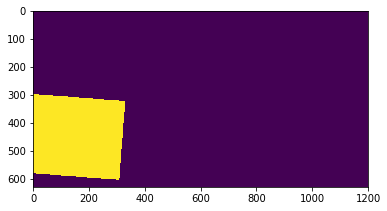

In [8]:
from PIL import Image

for index in range(5):
    image = dataset_train.load_image(index)
    mask, clss = dataset_train.load_mask(index)
#     print('before', image.shape, mask.shape, clss)
#     if len(clss) == 0:
#         image = augs.augment_color(image)[0]
#     else:
#         image, mask = augs.augment_color(image, mask)
#         if len(mask.shape) == 2:
#             mask = mask[:, :, np.newaxis]
#     print('after', image.shape, mask.shape)
#     plt.imshow(img)
#     plt.show()
#     plt.imshow(masks[:, :, 0])
#     plt.show()

def rotate(img, angle):
    return np.array(Image.fromarray(img).rotate(angle))

for ch in range(mask.shape[-1]):
    mask[:, :, ch] = rotate(mask[:, :, ch], -4.4)

plt.imshow(rotate(image, -4))
plt.show()
plt.imshow(mask[:, :, 0])
plt.show()


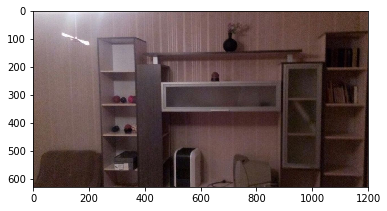

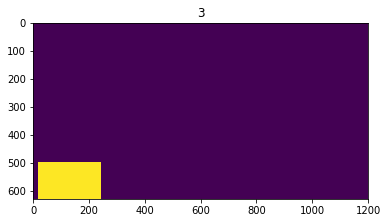

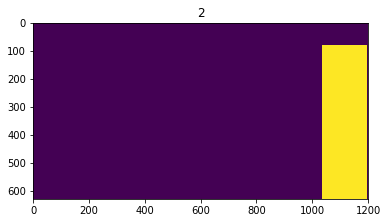

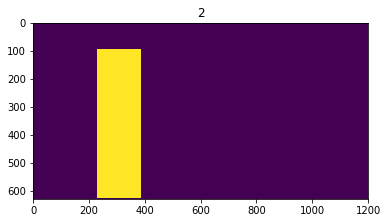

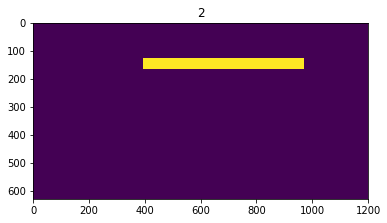

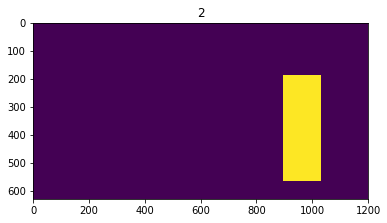

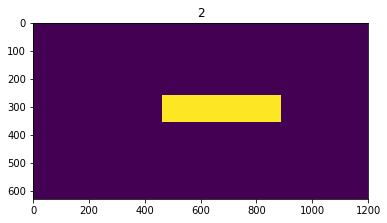

In [9]:
index = 1
plt.imshow(dataset_train.load_image(index))
plt.show()
masks, clss = dataset_train.load_mask(index)
for i in range(masks.shape[-1]):
    plt.imshow(masks[:, :, i])
    plt.title(clss[i])
    plt.show()

In [10]:
class MyConfig(Config):
    NAME = "furniture"

    IMAGES_PER_GPU = 2
    
    IMAGE_MIN_DIM = 576
    IMAGE_MAX_DIM = 768

    # Uncomment to train on 8 GPUs (default is 1)
    GPU_COUNT = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + len(classes)

In [11]:
config = MyConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[192 192]
 [ 96  96]
 [ 48  48]
 [ 24  24]
 [ 12  12]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      2
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  768
IMAGE_MIN_DIM                  576
IMAGE_PADDING                  True
IMAGE_SHAPE                    [768 768   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           furniture
NUM_CLASSES                    10
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAIN

In [12]:
model = modellib.MaskRCNN(
    mode="training", 
    config=config,
    model_dir=MODEL_DIR
)

In [13]:
model.load_weights(
    './experiments/attempt4/furniture20180317T0042/mask_rcnn_furniture_0001.h5', 
    by_name=True
    # exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
)

In [ ]:
print("Training network heads")
model.train(
    dataset_train, dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=5,
    layers='heads',
    reset_epoch=True
)

In [14]:
# Training - Stage 2
# Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            layers='4+',
            reset_epoch=True)

Fine tune Resnet stage 4 and up

Starting at epoch 0. LR=0.001

Checkpoint Path: /src/experiments/attempt4/furniture20180317T0042/mask_rcnn_furniture_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Epoch 1/10


/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


   1/1000 [..............................] - ETA: 9543s - loss: 0.5586 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.1826 - mrcnn_class_loss: 0.1573 - mrcnn_bbox_loss: 0.2066 - mrcnn_mask_loss: 0.0000e+00

/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


1000/1000 [==============================] - 1482s - loss: 0.3965 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.1434 - mrcnn_class_loss: 0.0931 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 1.3753 - val_rpn_class_loss: 0.0519 - val_rpn_bbox_loss: 0.7408 - val_mrcnn_class_loss: 0.2573 - val_mrcnn_bbox_loss: 0.3252 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 2/10
1000/1000 [==============================] - 1450s - loss: 0.3675 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1315 - mrcnn_class_loss: 0.0851 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 1.7500 - val_rpn_class_loss: 0.0628 - val_rpn_bbox_loss: 0.9171 - val_mrcnn_class_loss: 0.3627 - val_mrcnn_bbox_loss: 0.4074 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 3/10
  33/1000 [..............................] - ETA: 1407s - loss: 0.3650 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1292 - mrcnn_class_loss: 0.0824 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
# Training - Stage 3
# Fine tune all layers
print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=100,
            layers='all')

Fine tune all layers

Starting at epoch 2. LR=0.0001

Checkpoint Path: /src/experiments/attempt4/furniture20180317T0042/mask_rcnn_furniture_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b 

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 3/100
   1/1000 [..............................] - ETA: 5935s - loss: 0.2491 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.1351 - mrcnn_mask_loss: 0.0000e+00

/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


   4/1000 [..............................] - ETA: 2077s - loss: 0.2782 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0976 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.1104 - mrcnn_mask_loss: 0.0000e+00

/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


1000/1000 [==============================] - 826s - loss: 0.3086 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1067 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 1.9771 - val_rpn_class_loss: 0.0237 - val_rpn_bbox_loss: 1.3273 - val_mrcnn_class_loss: 0.1025 - val_mrcnn_bbox_loss: 0.5235 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 4/100
 280/1000 [=======>......................] - ETA: 582s - loss: 0.3011 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1088 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.1163 - mrcnn_mask_loss: 0.0000e+00

In [121]:
class InferenceConfig(MyConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

model.load_weights(
    './experiments/attempt2/furniture20180317T0042/mask_rcnn_furniture_0005.h5',
    by_name=True
)

In [ ]:
for i in range(50, 100):
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(
        dataset_train, 
        inference_config, 
        i, 
        use_mini_mask=False
    )

    results = model.detect([original_image], verbose=0)

    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], ax=get_ax())

Processing 1 images
image                    shape: (768, 768, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 768, 768, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 18)               min:    0.00000  max:  768.00000


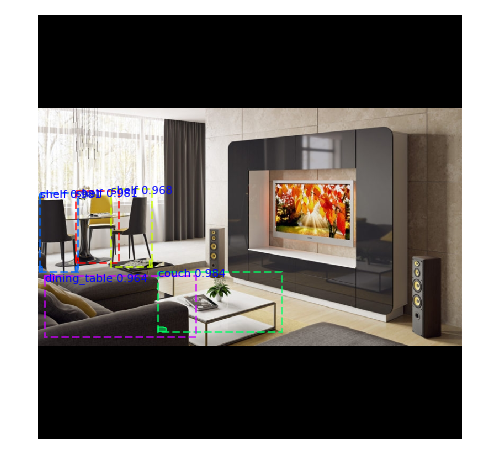

In [118]:
test_data_dirpath = '/data/images_test'
id = 4
img_filepath = join(test_data_dirpath, '%06d.jpg' % (int(id)))
if not os.path.exists(img_filepath):
    print('No image {}'.format(id))
else:
    img = cv2.imread(img_filepath)[:, :, ::-1]
    img_copy = img.copy()
    h, w = img.shape[:2]
    img, window, scale, padding = my_resize(img, inference_config)
    results = model.detect([img], verbose=1)

    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], ax=get_ax())

# test

In [160]:
def my_resize(image, config):
    image, window, scale, padding = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        max_dim=config.IMAGE_MAX_DIM,
        padding=config.IMAGE_PADDING
    )
    return image, window, scale, padding

In [161]:
test_data = pd.read_csv('/data/sample_submission.csv')
print(len(test_data))
test_data.head()

3713


,id,input,prediction
0,0,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""lamp"": [], ""armchair"": [], ""dining_..."
1,1,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""lamp"": [], ""armchair"": [], ""dining_..."
2,2,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""lamp"": [], ""armchair"": [], ""dining_..."
3,3,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""lamp"": [], ""armchair"": [[[0.5962732..."
4,4,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""lamp"": [], ""armchair"": [], ""dining_..."


In [101]:
test_data.loc[10]['prediction']

'{"aabb": {"lamp": [], "couch": [], "shelf": [[[0.10546875, 0.5227686703096539], [0.10546875, 0.7122040072859745], [0.17708333333333334, 0.7122040072859745], [0.17708333333333334, 0.5227686703096539], [0.10546875, 0.5227686703096539]]], "bed": [[[0.3684895833333333, 0.4899817850637523], [0.3684895833333333, 0.8269581056466303], [0.8424479166666666, 0.8269581056466303], [0.8424479166666666, 0.4899817850637523], [0.3684895833333333, 0.4899817850637523]]], "armchair": [[[0.6783854166666666, 0.23679417122040075], [0.6783854166666666, 0.3041894353369763], [0.8815104166666666, 0.3041894353369763], [0.8815104166666666, 0.23679417122040075], [0.6783854166666666, 0.23679417122040075]], [[0.057291666666666664, 0.14936247723132967], [0.057291666666666664, 0.575591985428051], [0.2591145833333333, 0.575591985428051], [0.2591145833333333, 0.14936247723132967], [0.057291666666666664, 0.14936247723132967]]], "chair": [], "wardrobe": [], "dining_table": [], "desk": [[[0.8528645833333334, 0.355191256830

In [166]:
test_data_dirpath = '/data/images_test'
for k, v in list(test_data.iterrows()):
    id = int(v['id'])
    img_filepath = join(test_data_dirpath, '%06d.jpg' % (int(id)))
    if k % 100 == 0:
        print(k)
    if not os.path.exists(img_filepath):
        print('No image {}'.format(id))
        continue
    else:
        img = cv2.imread(img_filepath)[:, :, ::-1]
        img_copy = img.copy()
        h, w = img.shape[:2]
        img, window, scale, padding = my_resize(img, inference_config)
        
        results = model.detect([img], verbose=0)

        r = results[0]
        
        n = len(r['scores'])
        result_json = {cls: [] for cls in classes}
        for i in range(n):
            class_id, roi, score = (
                r['class_ids'][i],
                r['rois'][i],
                r['scores'][i]
            )
            if score < 0.9:
                continue
            cls = dataset_val.class_names[class_id]
            top_pad, left_pad = window[:2]
            def translate(x, y):
                x = ((x - left_pad) / scale) / w
                y = ((y - top_pad) / scale) / h
                return x, y
            top, left, bottom, right = roi
            left, top = translate(left, top)
            right, bottom = translate(right, bottom)
            
            rect = [
                [left, top],
                [left, bottom],
                [right, bottom],
                [right, top],
                [left, top]
            ]
            
            result_json[cls].append(rect)
            
        result_json = {'aabb': result_json}
        test_data.set_value(k, 'prediction', json.dumps(result_json))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700


In [167]:
test_data.to_csv('/data/submisssions/epoch60_2_ruslan.csv', index=None)

In [112]:
dataset_train.class_names

['BG',
 'chair',
 'armchair',
 'lamp',
 'desk',
 'dining_table',
 'couch',
 'shelf',
 'bed',
 'wardrobe']

In [110]:
dataset_val.class_names

['BG',
 'chair',
 'armchair',
 'lamp',
 'desk',
 'dining_table',
 'couch',
 'shelf',
 'bed',
 'wardrobe']

In [108]:
test_data.head()

,id,input,prediction
0,0,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""lamp"": [], ""couch"": [], ""shelf"": [[..."
1,1,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""lamp"": [], ""couch"": [[[0.2942708333..."
2,2,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""lamp"": [], ""couch"": [], ""shelf"": []..."
3,3,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""lamp"": [], ""couch"": [[[0.6848958333..."
4,4,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""lamp"": [], ""couch"": [[[0.2825520833..."
